In [1]:
import tensorflow as tf
import tensorflow_gnn as tfgnn
import tensorflow_datasets as tfds
import numpy as np
from matplotlib import pyplot as plt
from Parsing import *
from Displaying import *

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

c:\Users\FaceInCake\Saves\4740_Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Num GPUs Available:  0


In [2]:
# Configurables

IMAGE_SIZE = (256, 256)

SUPERPIXELS = 512


# Load in the data
**`(data being image paths and annotations)`**

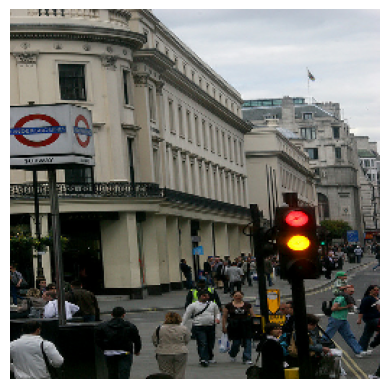

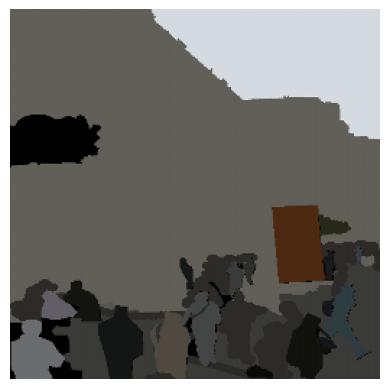

In [3]:
# Call to tfds.load


from functools import reduce

ds_train :tf.data.Dataset = tfds.load('coco/2017_panoptic', split='train', shuffle_files=True) # type: ignore
ds_val :tf.data.Dataset = tfds.load('coco/2017_panoptic', split='validation', shuffle_files=True) # type: ignore

def process_datapoint (dp):
    dp['image'] = tf.math.divide(
        tf.image.resize(dp['image'], IMAGE_SIZE, tf.image.ResizeMethod.BICUBIC),
        255.0
    )
    dp['panoptic_image'] = tf.math.divide(
        tf.image.resize(dp['panoptic_image'], IMAGE_SIZE, tf.image.ResizeMethod.BICUBIC),
        255.0
    )
    return dp

ds_train = ds_train.map(process_datapoint)
ds_val = ds_val.map(process_datapoint)

example = next(iter(ds_val.take(1)))
example_image = example['image']
plt.imshow(example_image)
plt.axis('off')
plt.show()
example_segmentations = example['panoptic_image']
plt.imshow(example_segmentations)
plt.axis('off')
plt.show()

# def draw_bbox (img, bbox):
#     return cv2.rectangle(img, bbox[0:2], bbox[2:4], (255, 255, 0))
# plt.imshow(reduce( # Show image with object bboxes
#     draw_bbox,
#     [example['panoptic_objects']['bbox'][i,:]
#         for i in range(example['panoptic_objects']['id'].shape[0])],
#     Mat(example['image'])
# ))
# plt.axis('off')
# plt.show()

In [15]:
# Generate example segmentation and graph

from skimage.segmentation import slic as slic_superpixels
from skimage.graph import rag_mean_color

example_segments = slic_superpixels(example_image, SUPERPIXELS)
example_graph = rag_mean_color(example_image, example_segments)

for region in example_graph:
    coords = np.column_stack(np.where(example_segments == region))
    centroid = np.mean(coords, axis=0) / 255.0 - 0.5
    example_graph.nodes[region]['centroid'] = centroid

example_graph.nodes[next(iter(example_graph))]

{'labels': [1],
 'pixel count': 142,
 'total color': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([100.70456,  97.02864,  90.82453], dtype=float32)>,
 'mean color': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.70918703, 0.6833003 , 0.6396094 ], dtype=float32)>,
 'centroid': array([-0.48218724, -0.47420602])}

In [26]:
# Load the Graph schema, the format of the graph
graph_schema = tfgnn.read_schema("graphSpec.pbtxt")
graph_spec = tfgnn.create_graph_spec_from_schema_pb(graph_schema)
graph_spec

GraphTensorSpec({'context': ContextSpec({'features': {}, 'sizes': TensorSpec(shape=(1,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, tf.int64, None), 'node_sets': {'cluster': NodeSetSpec({'features': {'hidden_state': TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)}, 'sizes': TensorSpec(shape=(1,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, tf.int64, None)}, 'edge_sets': {'neighbors': EdgeSetSpec({'features': {}, 'adjacency': AdjacencySpec({'#index.0': TensorSpec(shape=(None,), dtype=tf.int32, name=None), '#index.1': TensorSpec(shape=(None,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, tf.int64, {'#index.0': 'cluster', '#index.1': 'cluster'}), 'sizes': TensorSpec(shape=(1,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, tf.int64, None)}}, TensorShape([]), tf.int32, tf.int64, None)

In [63]:
def get_features (graph):
    return [
        tf.concat([x1,x2,[x3]], 0)
        for x1,x2,x3 in zip(
            list(zip(*graph.nodes('mean color')))[1], # Tensor shape=3,
            list(zip(*graph.nodes('centroid')))[1], # array[2]
            list(i / IMAGE_SIZE[0] / IMAGE_SIZE[1] for i in list(zip(*graph.nodes('pixel count')))[1]), # float
        )
    ]

get_features(example_graph)[0:4]

[<tf.Tensor: shape=(6,), dtype=float32, numpy=
 array([ 0.70918703,  0.6833003 ,  0.6396094 , -0.48218724, -0.47420603,
         0.00216675], dtype=float32)>,
 <tf.Tensor: shape=(6,), dtype=float32, numpy=
 array([ 0.58637005,  0.5696614 ,  0.5290411 , -0.48381838, -0.40934986,
         0.00289917], dtype=float32)>,
 <tf.Tensor: shape=(6,), dtype=float32, numpy=
 array([ 0.50052154,  0.49080977,  0.4518539 , -0.46418762, -0.37200484,
         0.00346375], dtype=float32)>,
 <tf.Tensor: shape=(6,), dtype=float32, numpy=
 array([ 0.5785448 ,  0.5573823 ,  0.51206064, -0.47822788, -0.30031446,
         0.00323486], dtype=float32)>]

In [64]:
# Function for converting a nx.Graph to a TensorGraph

from networkx import Graph

def graph_to_graphTensor (graph:Graph):
    source, target = zip(*graph.edges())
    node_indices = tuple(range(len(graph)))
    return tfgnn.GraphTensor.from_pieces(
        node_sets={
            'cluster': tfgnn.NodeSet.from_fields(
                sizes=[len(graph)], #type: ignore
                features={
                    'hidden_state': get_features(graph)
                }
            )
        },
        edge_sets={
            'neighbors': tfgnn.EdgeSet.from_fields(
                sizes=[len(graph)], #type: ignore
                features={},
                adjacency=tfgnn.Adjacency.from_indices(
                    source=('cluster', source + target + node_indices),
                    target=('cluster', target + source + node_indices)
                )
            )
        }
    )

example_graphTensor = graph_to_graphTensor(example_graph)
example_graphTensor.node_sets

{'cluster': NodeSet(features={'hidden_state': <tf.Tensor: shape=(388, 6), dtype=tf.float32>}, sizes=[388])}

In [66]:

NODE_DIMENSION = 64
EDGE_DIMENSION = 16
MESSAGE_DIMENSION = 64
MESSAGE_PASSING_ITERATIONS = 3
NEXT_STATE_DIMENSION = 64

def build_model():
    input_graph = tf.keras.layers.Input(type_spec=graph_spec)
    graph = input_graph.merge_batch_to_components() # graph is homo, might as well merge to components
    
    print(graph.node_sets['cluster'].features['hidden_state'])
    
    # graph.node_sets['cluster'].features['hidden_state'] = tf.keras.layers.Concatenate(axis=1)([
    #     graph.node_sets['cluster']['mean_clr'],
    #     graph.node_sets['cluster']['centroid'],
    #     tf.math.divide(graph.node_sets['cluster']['pixel_count'], IMAGE_SIZE[0]*IMAGE_SIZE[1])
    # ])

    # def set_initial_node_state(node_set, *, node_set_name):
    #     return tf.keras.layers.Dense(NODE_DIMENSION)(node_set)
    # def set_initial_edge_state(edge_set, *, edge_set_name):
    #     return tf.keras.layers.Dense(EDGE_DIMENSION)(edge_set)
    # graph = tfgnn.keras.layers.MapFeatures(
    #     node_sets_fn=set_initial_node_state,
    #     edge_sets_fn=set_initial_edge_state
    # )(graph)

    def message_func(dimen):
        return tf.keras.layers.Dense(
            dimen,
            activation='relu'
        )

    for i in range(MESSAGE_PASSING_ITERATIONS):
        graph = tfgnn.keras.layers.GraphUpdate(
            node_sets={
                'cluster': tfgnn.keras.layers.NodeSetUpdate({
                    'neighbors': tfgnn.keras.layers.SimpleConv(
                        message_fn=message_func(MESSAGE_DIMENSION)
                    )
                },
                tfgnn.keras.layers.NextStateFromConcat(message_func(NEXT_STATE_DIMENSION))
                )
            }
        )(graph)
    
    def map_node_to_rgb (node_set):
        return tf.Tensor
    graph = tfgnn.keras.layers.MapFeatures(
        node_sets_fn=map_node_to_rgb
    )(graph)
    
    return tf.keras.Model(inputs=[input_graph], outputs=[])

model = build_model()
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'input.features_4'")


TypeError: Exception encountered when calling layer "map_features" (type MapFeatures).

build_model.<locals>.map_node_to_rgb() got an unexpected keyword argument 'node_set_name'

Call arguments received by layer "map_features" (type MapFeatures):
  • graph=GraphTensor(
  context=Context(features={}, sizes=Tensor("Placeholder:0", shape=(1,), dtype=int32), shape=(), indices_dtype=tf.int32),
  node_set_names=['cluster'],
  edge_set_names=['neighbors'])

## Example Image

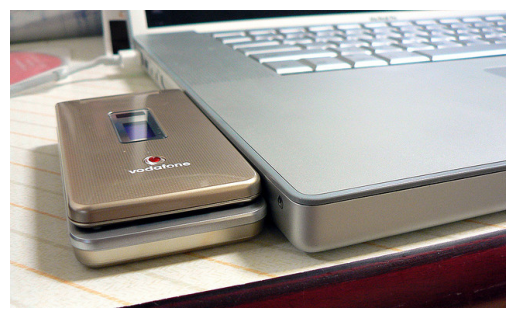

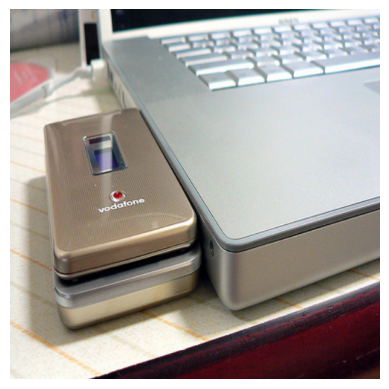

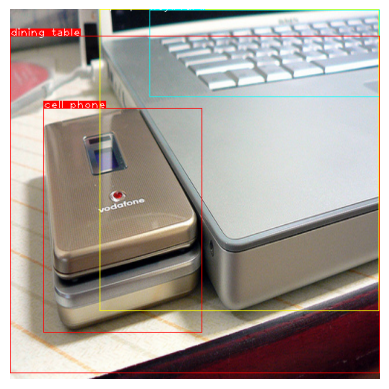

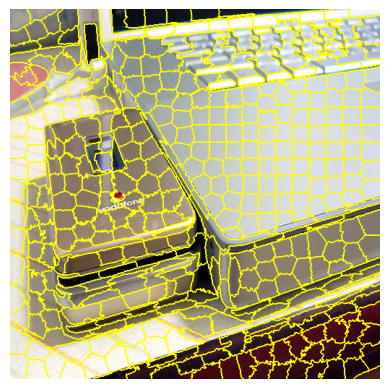

In [21]:
# Super pixel generation example

from Processing import img_to_superpixels
from skimage.segmentation import mark_boundaries

rand_id = choice(list(imageList_val.keys()))
rand_img = process_image("Data/val2017/"+imageList_val[rand_id].fileName)

labels = img_to_superpixels(rand_img, 512)
mask = mark_boundaries(rand_img, labels)

# fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4)
plt.imshow(cvtColor(
    imread("Data/val2017/"+imageList_val[rand_id].fileName, IMREAD_COLOR),
    COLOR_BGR2RGB
))
plt.axis('off')
plt.show()

plt.imshow(rand_img)
plt.axis('off')
plt.show()

plt.imshow(reduce( # Show image with object bboxes
    draw_obj,
    [o for o in objectList_val.values() if o.image.id == rand_id],
    rand_img
))
plt.axis('off')
plt.show()

plt.imshow(mask)
plt.axis('off')
plt.show()


# Build the Model

In [ ]:

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the Model

In [ ]:
# Configurables for training
EPOCHS = 2
INITIAL_EPOCH = 1

model.fit(
    x = x_train,
    y = None,
    epochs = EPOCHS,
    validations_data = x_val,
    initial_epoch = INITIAL_EPOCH
)